保存图像: hamrank_quanonet/logs/Homogeneous/rank_errors.png
保存数据: hamrank_quanonet/logs/Homogeneous/rank_errors.csv


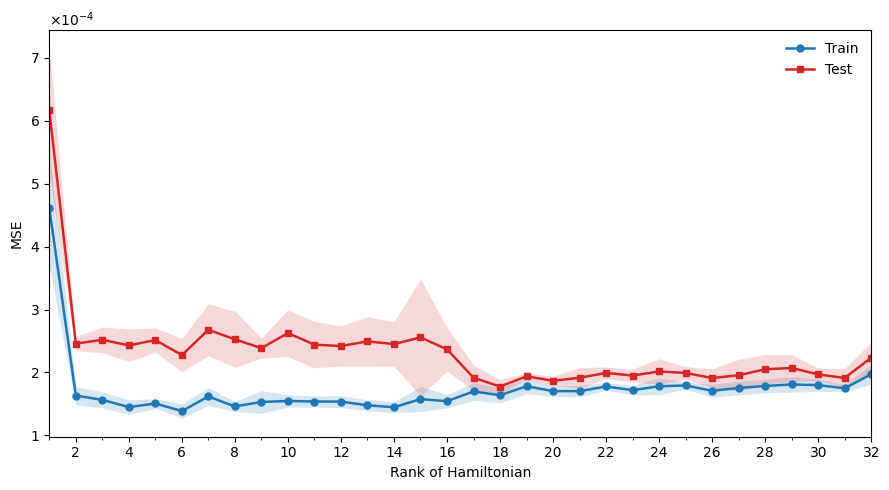

In [18]:
#!/usr/bin/env python3
import os
import json
import math
from glob import glob
from typing import List, Dict, Any, Tuple

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MultipleLocator


def safe_min_train_loss(training_history: List[Dict[str, Any]]) -> float:
    if not isinstance(training_history, list) or len(training_history) == 0:
        return math.nan
    vals = []
    for rec in training_history:
        try:
            v = float(rec.get("train_loss"))
            if math.isfinite(v):
                vals.append(v)
        except Exception:
            continue
    return float(min(vals)) if vals else math.nan


def safe_results_mse(results: Dict[str, Any]) -> float:
    if not isinstance(results, dict):
        return math.nan
    try:
        v = float(results.get("MSE"))
        return v if math.isfinite(v) else math.nan
    except Exception:
        return math.nan


def collect_rank_metrics(base_dir: str, rank_from: int = 1, rank_to: int = 32) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    ranks = []
    train_means = []
    train_stds = []
    test_means = []
    test_stds = []

    for r in range(rank_from, rank_to + 1):
        rank_dir = os.path.join(base_dir, f"rank{r}")
        if not os.path.isdir(rank_dir):
            # 跳过不存在的 rank 目录
            continue
        files = sorted(glob(os.path.join(rank_dir, "*.json")))
        if not files:
            continue

        train_vals = []
        test_vals = []
        for fp in files:
            try:
                with open(fp, "r", encoding="utf-8") as f:
                    data = json.load(f)
            except Exception:
                continue

            train_vals.append(safe_min_train_loss(data.get("training_history")))
            test_vals.append(safe_results_mse(data.get("results")))

        # 过滤 NaN
        train_arr = np.array([v for v in train_vals if isinstance(v, (int, float)) and math.isfinite(v)], dtype=float)
        test_arr = np.array([v for v in test_vals if isinstance(v, (int, float)) and math.isfinite(v)], dtype=float)
        if train_arr.size == 0 and test_arr.size == 0:
            continue

        ranks.append(r)
        train_means.append(float(np.mean(train_arr)) if train_arr.size else math.nan)
        train_stds.append(float(np.std(train_arr, ddof=0)) if train_arr.size else math.nan)
        test_means.append(float(np.mean(test_arr)) if test_arr.size else math.nan)
        test_stds.append(float(np.std(test_arr, ddof=0)) if test_arr.size else math.nan)

    return (
        np.array(ranks, dtype=int),
        np.array(train_means, dtype=float),
        np.array(train_stds, dtype=float),
        np.array(test_means, dtype=float),
        np.array(test_stds, dtype=float),
    )


def plot_with_shade(x: np.ndarray, y: np.ndarray, ystd: np.ndarray, label: str, color: str, marker: str = "o", ax=None):
    ax = ax or plt.gca()
    ax.plot(x, y, label=label, color=color, marker=marker, linewidth=1.8, markersize=5)
    # 仅对非 NaN 位置绘制阴影
    mask = np.isfinite(y) & np.isfinite(ystd)
    if np.any(mask):
        ax.fill_between(x[mask], y[mask] - ystd[mask], y[mask] + ystd[mask], color=color, alpha=0.18, linewidth=0)



base_dir = os.path.join("hamrank_quanonet", "logs", "Homogeneous")
ranks, train_mean, train_std, test_mean, test_std = collect_rank_metrics(base_dir, 1, 32)

fig, ax = plt.subplots(figsize=(9, 5))
plot_with_shade(ranks, train_mean, train_std, label="Train", color="#1f77b4", marker="o", ax=ax)
plot_with_shade(ranks, test_mean, test_std, label="Test", color="#d62728", marker="s", ax=ax)

# 轴与网格美化
ax.set_xlabel("Rank of Hamiltonian")
ax.set_ylabel("MSE")
ax.set_xlim(1, 32)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.grid(True, which="major", alpha=0.35, linestyle="--", linewidth=0.7)
# ax.grid(True, which="minor", alpha=0.12, linestyle=":", linewidth=0.6)

# Y 轴以 ×10^{-4} 显示
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
ax.yaxis.get_offset_text().set_size(10)

ax.legend(frameon=False)
fig.tight_layout()

out_dir = base_dir
os.makedirs(out_dir, exist_ok=True)
png_path = os.path.join(out_dir, "rank_errors.png")
plt.savefig(png_path, dpi=180)
print(f"保存图像: {png_path}")

# 同时导出一个 CSV 便于后续处理
csv_path = os.path.join(out_dir, "rank_errors.csv")
import csv
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["rank", "train_mean", "train_std", "test_mean", "test_std"])
    for i in range(len(ranks)):
        writer.writerow([int(ranks[i]), train_mean[i], train_std[i], test_mean[i], test_std[i]])
print(f"保存数据: {csv_path}")


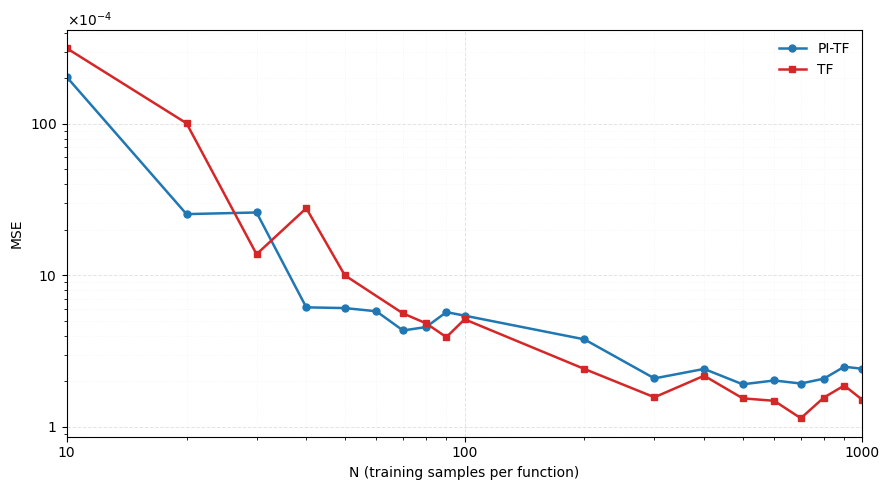

保存图像: PI/logs/Nonlinear/MSE_vs_N_logx_compare.png
保存数据: PI/logs/Nonlinear/MSE_vs_N_PI-TF.csv
保存数据: PI/logs/Nonlinear/MSE_vs_N_TF.csv
PI-TF 点数: 19; TF 点数: 18


In [24]:
# 绘制 PI/logs/Nonlinear 下 MSE 随 N 的折线图（x 轴对数；叠加 PI-TF 与 TF 两种命名）
from pathlib import Path
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator, LogFormatter

base_dir = Path('PI/logs/Nonlinear')
S = 10
net_label = "[20, 2, 10, 2]"  # 目标网络标签
Ns = list(range(10, 101, 10)) + list(range(200, 1001, 100))

def read_mse(fp: Path):
    try:
        with open(fp, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception:
        return None
    if isinstance(data, dict):
        if 'MSE' in data and isinstance(data['MSE'], (int, float)):
            try:
                v = float(data['MSE'])
                return v if math.isfinite(v) else None
            except Exception:
                return None
        if 'results' in data and isinstance(data['results'], dict) and 'MSE' in data['results']:
            try:
                v = float(data['results']['MSE'])
                return v if math.isfinite(v) else None
            except Exception:
                return None
    return None

pairs_a, missing_a = [], []  # PI-TF
pairs_b, missing_b = [], []  # TF

for N in Ns:
    # 格式 A（PI-TF，带下划线，例：..._{N}*{S}_5_[...].json）
    f_a = base_dir / f"train_Nonlinear_PI-TF-QuanONet_{N}*{S}_5_{net_label}_0.001_0.json"
    if f_a.exists():
        mse = read_mse(f_a)
        if mse is not None:
            pairs_a.append((N, mse))
        else:
            print(f"文件存在但无有效 MSE: {f_a}")
    else:
        missing_a.append((N, str(f_a)))

    # 格式 B（TF），尝试两种常见命名：
    #   1) 带下划线：..._{N}*{S}_5_[...].json
    #   2) 无下划线（用户提供变体）：..._{N}*{S}5[...].json
    candidates_b = [
        base_dir / f"train_Nonlinear_TF-QuanONet_{N}*{S}_5_{net_label}_0.001_0.json",
        base_dir / f"train_Nonlinear_TF-QuanONet_{N}*{S}5{net_label}_0.001_0.json",
    ]
    found_b = False
    for f_b in candidates_b:
        if f_b.exists():
            mse = read_mse(f_b)
            if mse is not None:
                pairs_b.append((N, mse))
                found_b = True
                break  # 同一 N 取第一个匹配的命名
            else:
                print(f"文件存在但无有效 MSE: {f_b}")
                found_b = True
                break
    if not found_b:
        # 仅记录第一个候选作为缺失提示
        missing_b.append((N, str(candidates_b[0])))

if not pairs_a and not pairs_b:
    print("未找到任何可用的 JSON 数据，请确认文件是否已生成且路径/命名一致。")
else:
    fig, ax = plt.subplots(figsize=(9, 5))

    # 绘制 A（PI-TF）
    if pairs_a:
        pairs_a.sort(key=lambda x: x[0])
        Ns_a = np.array([p[0] for p in pairs_a], dtype=int)
        MSE_a = np.array([p[1] for p in pairs_a], dtype=float)
        ax.plot(Ns_a, MSE_a, color='#1f77b4', marker='o', linewidth=1.8, markersize=5, label='PI-TF')
    # 绘制 B（TF）
    if pairs_b:
        pairs_b.sort(key=lambda x: x[0])
        Ns_b = np.array([p[0] for p in pairs_b], dtype=int)
        MSE_b = np.array([p[1] for p in pairs_b], dtype=float)
        ax.plot(Ns_b, MSE_b, color='#d62728', marker='s', linewidth=1.8, markersize=5, label='TF')

    # 轴与网格：x 轴对数坐标
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)
    ax.set_xlim(10, 1000)
    # 主刻度在 10, 100, 1000；次刻度为 2..9
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=12))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=tuple(range(2, 10)), numticks=12))
    ax.xaxis.set_major_formatter(LogFormatter(base=10.0))

    ax.set_xlabel('N (training samples per function)')
    ax.set_ylabel('MSE')
    ax.grid(True, which='major', alpha=0.35, linestyle='--', linewidth=0.7)
    ax.grid(True, which='minor', alpha=0.12, linestyle=':', linewidth=0.6)

    # Y 轴科学计数法：固定到 1e-4 的量级（若值并非该量级仍会按实际范围显示）
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
    ax.yaxis.get_offset_text().set_size(10)

    # 图例与输出
    ax.legend(frameon=False)
    fig.tight_layout()

    out_png = base_dir / 'MSE_vs_N_logx_compare.png'
    fig.savefig(out_png, dpi=180)
    plt.show()
    print(f'保存图像: {out_png}')

    # 导出 CSV
    import csv
    if pairs_a:
        out_csv_a = base_dir / 'MSE_vs_N_PI-TF.csv'
        with open(out_csv_a, 'w', newline='', encoding='utf-8') as f:
            w = csv.writer(f)
            w.writerow(['N', 'MSE'])
            for N, mse in pairs_a:
                w.writerow([N, mse])
        print(f'保存数据: {out_csv_a}')
    if pairs_b:
        out_csv_b = base_dir / 'MSE_vs_N_TF.csv'
        with open(out_csv_b, 'w', newline='', encoding='utf-8') as f:
            w = csv.writer(f)
            w.writerow(['N', 'MSE'])
            for N, mse in pairs_b:
                w.writerow([N, mse])
        print(f'保存数据: {out_csv_b}')

    # 统计提示，帮助排查为何只出现一条曲线
    print(f"PI-TF 点数: {len(pairs_a)}; TF 点数: {len(pairs_b)}")
    if not pairs_b:
        print("提示: 未找到 TF 命名的数据点。已同时尝试带下划线与不带下划线两种命名，请核对文件名。")

In [ ]:
# 绘制 PI/logs/Nonlinear 下 MSE 随 N 的折线图（x 轴对数；叠加 PI-TF 与 TF 两种命名）
from pathlib import Path
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, LogLocator, LogFormatter

base_dir = Path('PI/logs/Nonlinear')
S = 10
net_label = "[20, 2, 10, 2]"  # 目标网络标签
Ns = list(range(10, 101, 10)) + list(range(200, 1001, 100))

def read_mse(fp: Path):
    try:
        with open(fp, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception:
        return None
    if isinstance(data, dict):
        if 'MSE' in data and isinstance(data['MSE'], (int, float)):
            try:
                v = float(data['MSE'])
                return v if math.isfinite(v) else None
            except Exception:
                return None
        if 'results' in data and isinstance(data['results'], dict) and 'MSE' in data['results']:
            try:
                v = float(data['results']['MSE'])
                return v if math.isfinite(v) else None
            except Exception:
                return None
    return None

pairs_a, missing_a = [], []  # PI-TF
pairs_b, missing_b = [], []  # TF

for N in Ns:
    # 格式 A（PI-TF，带下划线，例：..._{N}*{S}_5_[...].json）
    f_a = base_dir / f"train_Nonlinear_PI-TF-QuanONet_{N}*{S}_5_{net_label}_0.001_0.json"
    if f_a.exists():
        mse = read_mse(f_a)
        if mse is not None:
            pairs_a.append((N, mse))
        else:
            print(f"文件存在但无有效 MSE: {f_a}")
    else:
        missing_a.append((N, str(f_a)))

    # 格式 B（TF），尝试两种常见命名：
    #   1) 带下划线：..._{N}*{S}_5_[...].json
    #   2) 无下划线（用户提供变体）：..._{N}*{S}5[...].json
    candidates_b = [
        base_dir / f"train_Nonlinear_TF-QuanONet_{N}*{S}_5_{net_label}_0.001_0.json",
        base_dir / f"train_Nonlinear_TF-QuanONet_{N}*{S}5{net_label}_0.001_0.json",
    ]
    found_b = False
    for f_b in candidates_b:
        if f_b.exists():
            mse = read_mse(f_b)
            if mse is not None:
                pairs_b.append((N, mse))
                found_b = True
                break  # 同一 N 取第一个匹配的命名
            else:
                print(f"文件存在但无有效 MSE: {f_b}")
                found_b = True
                break
    if not found_b:
        # 仅记录第一个候选作为缺失提示
        missing_b.append((N, str(candidates_b[0])))

if not pairs_a and not pairs_b:
    print("未找到任何可用的 JSON 数据，请确认文件是否已生成且路径/命名一致。")
else:
    fig, ax = plt.subplots(figsize=(9, 5))

    # 绘制 A（PI-TF）
    if pairs_a:
        pairs_a.sort(key=lambda x: x[0])
        Ns_a = np.array([p[0] for p in pairs_a], dtype=int)
        MSE_a = np.array([p[1] for p in pairs_a], dtype=float)
        ax.plot(Ns_a, MSE_a, color='#1f77b4', marker='o', linewidth=1.8, markersize=5, label='PI-TF')
    # 绘制 B（TF）
    if pairs_b:
        pairs_b.sort(key=lambda x: x[0])
        Ns_b = np.array([p[0] for p in pairs_b], dtype=int)
        MSE_b = np.array([p[1] for p in pairs_b], dtype=float)
        ax.plot(Ns_b, MSE_b, color='#d62728', marker='s', linewidth=1.8, markersize=5, label='TF')

    # 轴与网格：x 轴对数坐标
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=10)
    ax.set_xlim(10, 1000)
    # 主刻度在 10, 100, 1000；次刻度为 2..9
    ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=12))
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=tuple(range(2, 10)), numticks=12))
    ax.xaxis.set_major_formatter(LogFormatter(base=10.0))

    ax.set_xlabel('N (training samples per function)')
    ax.set_ylabel('MSE')
    ax.grid(True, which='major', alpha=0.35, linestyle='--', linewidth=0.7)
    ax.grid(True, which='minor', alpha=0.12, linestyle=':', linewidth=0.6)

    # Y 轴科学计数法：固定到 1e-4 的量级（若值并非该量级仍会按实际范围显示）
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
    ax.yaxis.get_offset_text().set_size(10)

    # 图例与输出
    ax.legend(frameon=False)
    fig.tight_layout()

    out_png = base_dir / 'MSE_vs_N_logx_compare.png'
    fig.savefig(out_png, dpi=180)
    plt.show()
    print(f'保存图像: {out_png}')

    # 导出 CSV
    import csv
    if pairs_a:
        out_csv_a = base_dir / 'MSE_vs_N_PI-TF.csv'
        with open(out_csv_a, 'w', newline='', encoding='utf-8') as f:
            w = csv.writer(f)
            w.writerow(['N', 'MSE'])
            for N, mse in pairs_a:
                w.writerow([N, mse])
        print(f'保存数据: {out_csv_a}')
    if pairs_b:
        out_csv_b = base_dir / 'MSE_vs_N_TF.csv'
        with open(out_csv_b, 'w', newline='', encoding='utf-8') as f:
            w = csv.writer(f)
            w.writerow(['N', 'MSE'])
            for N, mse in pairs_b:
                w.writerow([N, mse])
        print(f'保存数据: {out_csv_b}')

    # 统计提示，帮助排查为何只出现一条曲线
    print(f"PI-TF 点数: {len(pairs_a)}; TF 点数: {len(pairs_b)}")
    if not pairs_b:
        print("提示: 未找到 TF 命名的数据点。已同时尝试带下划线与不带下划线两种命名，请核对文件名。")

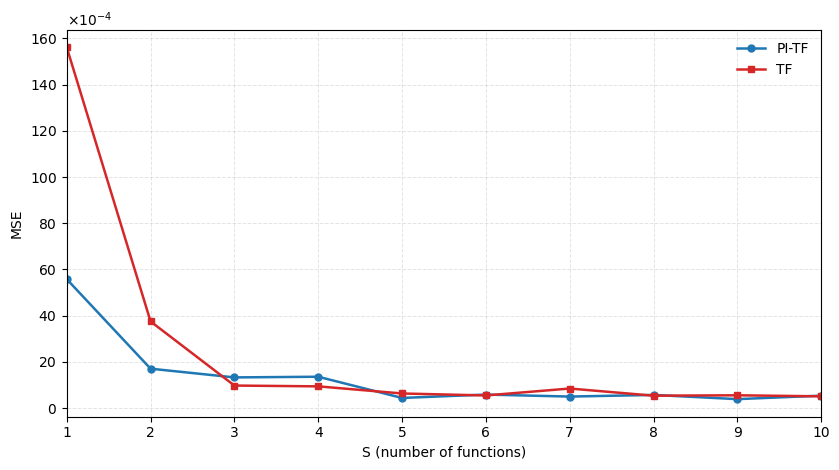

保存图像: PI/logs/Nonlinear/MSE_vs_S_at_N100_compare.png
保存数据: PI/logs/Nonlinear/MSE_vs_S_at_N100_PI-TF.csv
保存数据: PI/logs/Nonlinear/MSE_vs_S_at_N100_TF.csv
PI-TF 点数: 10; TF 点数: 10


In [25]:
# N 固定为 100，S=1..10，绘制 PI-TF 与 TF 两条曲线进行对比
from pathlib import Path
import json
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MultipleLocator

base_dir = Path('PI/logs/Nonlinear')
N = 100
S_list = list(range(1, 11))
net_label = "[20, 2, 10, 2]"

def read_mse(fp: Path):
    try:
        with open(fp, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except Exception:
        return None
    if isinstance(data, dict):
        if 'MSE' in data and isinstance(data['MSE'], (int, float)):
            try:
                v = float(data['MSE'])
                return v if math.isfinite(v) else None
            except Exception:
                return None
        if 'results' in data and isinstance(data['results'], dict) and 'MSE' in data['results']:
            try:
                v = float(data['results']['MSE'])
                return v if math.isfinite(v) else None
            except Exception:
                return None
    return None

pairs_a, missing_a = [], []  # PI-TF
pairs_b, missing_b = [], []  # TF

for S in S_list:
    # PI-TF：..._{N}*{S}_5_[...].json
    f_a = base_dir / f"train_Nonlinear_PI-TF-QuanONet_{N}*{S}_5_{net_label}_0.001_0.json"
    if f_a.exists():
        mse = read_mse(f_a)
        if mse is not None:
            pairs_a.append((S, mse))
        else:
            print(f"文件存在但无有效 MSE: {f_a}")
    else:
        missing_a.append((S, str(f_a)))

    # TF：尝试两种命名
    candidates_b = [
        base_dir / f"train_Nonlinear_TF-QuanONet_{N}*{S}_5_{net_label}_0.001_0.json",
        base_dir / f"train_Nonlinear_TF-QuanONet_{N}*{S}5{net_label}_0.001_0.json",
    ]
    found_b = False
    for f_b in candidates_b:
        if f_b.exists():
            mse = read_mse(f_b)
            if mse is not None:
                pairs_b.append((S, mse))
                found_b = True
                break
            else:
                print(f"文件存在但无有效 MSE: {f_b}")
                found_b = True
                break
    if not found_b:
        missing_b.append((S, str(candidates_b[0])))

if not pairs_a and not pairs_b:
    print("未找到任何可用的 JSON 数据，请确认文件是否已生成且路径/命名一致。")
else:
    fig, ax = plt.subplots(figsize=(8.5, 4.8))

    if pairs_a:
        pairs_a.sort(key=lambda x: x[0])
        S_a = np.array([p[0] for p in pairs_a], dtype=int)
        MSE_a = np.array([p[1] for p in pairs_a], dtype=float)
        ax.plot(S_a, MSE_a, color='#1f77b4', marker='o', linewidth=1.8, markersize=5, label='PI-TF')
    if pairs_b:
        pairs_b.sort(key=lambda x: x[0])
        S_b = np.array([p[0] for p in pairs_b], dtype=int)
        MSE_b = np.array([p[1] for p in pairs_b], dtype=float)
        ax.plot(S_b, MSE_b, color='#d62728', marker='s', linewidth=1.8, markersize=5, label='TF')

    ax.set_xlabel('S (number of functions)')
    ax.set_ylabel('MSE')
    ax.set_xlim(1, 10)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, which='major', alpha=0.35, linestyle='--', linewidth=0.7)
    ax.grid(True, which='minor', alpha=0.12, linestyle=':', linewidth=0.6)

    # Y 轴科学计数法：固定到 1e-4 的量级（视数据范围自动调整显示）
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-4, -4))
    ax.yaxis.get_offset_text().set_size(10)

    ax.legend(frameon=False)
    fig.tight_layout()

    out_png = base_dir / 'MSE_vs_S_at_N100_compare.png'
    fig.savefig(out_png, dpi=180)
    plt.show()
    print(f'保存图像: {out_png}')

    # 导出 CSV
    import csv
    if pairs_a:
        out_csv_a = base_dir / 'MSE_vs_S_at_N100_PI-TF.csv'
        with open(out_csv_a, 'w', newline='', encoding='utf-8') as f:
            w = csv.writer(f)
            w.writerow(['S', 'MSE'])
            for S, mse in pairs_a:
                w.writerow([S, mse])
        print(f'保存数据: {out_csv_a}')
    if pairs_b:
        out_csv_b = base_dir / 'MSE_vs_S_at_N100_TF.csv'
        with open(out_csv_b, 'w', newline='', encoding='utf-8') as f:
            w = csv.writer(f)
            w.writerow(['S', 'MSE'])
            for S, mse in pairs_b:
                w.writerow([S, mse])
        print(f'保存数据: {out_csv_b}')

    print(f"PI-TF 点数: {len(pairs_a)}; TF 点数: {len(pairs_b)}")
    if not pairs_b:
        print("提示: 未找到 TF 命名的数据点。已同时尝试两种常见命名，请核对文件名。")